# CoDA — **Graph at episode XX** snapshots (uncertainty‑aware)

This notebook records the transition matrix `T` after **each episode** and
lets you render a *graph snapshot* at any episode number — i.e., “graph at episode XX.”
It uses the uncertainty‑aware split rule and online merge from `coda_trial_by_trial.py`.


In [1]:

import sys, numpy as np, matplotlib.pyplot as plt
sys.path.append('/mnt/data')
from coda_trial_by_trial import (
    CoDAAgent, CoDAConfig,
    GridEnvRightDownNoSelf, GridEnvRightDownNoCue,
    generate_episode
)

# --- Config ---
CUE = 5
N_ACQ, N_EXT = 250, 300
MAX_STEPS = 20

cfg = CoDAConfig(
    gamma=0.9, lam=0.8,
    theta_split=0.9, theta_merge=0.5,
    n_threshold=8,
    min_presence_episodes=8,
    min_effective_exposure=25.0,
    confidence=0.95
)

env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env, cfg)

# --- Run & record T after each episode ---
T_snapshots = []
ENV_snapshots = []   # shallow copies of clone dicts etc. for plotting
with_clones = False

def snapshot():
    # store a copy of T and minimal env bookkeeping for plotting
    T_snapshots.append(agent.get_T().copy())
    ENV_snapshots.append({
        "clone_dict": dict(agent.env.clone_dict),
        "reverse_clone_dict": dict(agent.env.reverse_clone_dict),
        "state_to_pos": dict(agent.env.state_to_pos),
        "pos_to_state": dict(agent.env.pos_to_state),
        "cue_states": list(agent.env.cue_states),
        "rewarded_terminals": list(agent.env.rewarded_terminals),
        "unrewarded_terminals": list(agent.env.unrewarded_terminals),
        "env_size": tuple(agent.env.env_size),
        "base_actions": dict(agent.env.base_actions),
        "n_states": agent.n_states
    })

for ep in range(1, N_ACQ+1):
    states, actions = generate_episode(env, T=agent.get_T() if with_clones else None, max_steps=MAX_STEPS)
    agent.update_with_episode(states, actions)
    if agent.maybe_split():
        with_clones = True
    snapshot()

# Extinction-like
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(agent.env.clone_dict)
env2.reverse_clone_dict = dict(agent.env.reverse_clone_dict)
agent.env = env2

for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
    states, actions = generate_episode(env2, T=agent.get_T(), max_steps=MAX_STEPS)
    agent.update_with_episode(states, actions)
    agent.maybe_merge()
    snapshot()

print(f"Recorded {len(T_snapshots)} episode snapshots.")


Recorded 550 episode snapshots.


## Helper — plot the graph at an episode index

In [2]:

def plot_graph_at_episode(ep_idx, prob_threshold=0.05, figsize=(6,6), title=None):
    """Render 'graph at episode XX'. Aggregates actions; draws an edge s→s' if any action has prob >= threshold.
    Clones are placed near their parent successors; cue/terminals are highlighted.
    """
    T = T_snapshots[ep_idx]
    meta = ENV_snapshots[ep_idx]
    n = meta['n_states']
    state_to_pos = meta['state_to_pos']
    pos_to_state = meta['pos_to_state']
    env_size = meta['env_size']
    clone_dict = meta['clone_dict']
    cue_states = set(meta['cue_states'])
    terminals = set(meta['rewarded_terminals']) | set(meta['unrewarded_terminals'])

    # --- compute 2D positions for all nodes ---
    import math
    baseN = env_size[0]*env_size[1]
    coords = {}
    # base grid states
    for s, (i,j) in state_to_pos.items():
        coords[s] = (j, -i)  # x=j, y=-i for top-left origin look
    # clones: place near their parent successor with small radial offsets
    # we infer the parent from clone_dict (clone_id -> original successor)
    offsets = {}
    for k,(cl, parent) in enumerate(clone_dict.items()):
        if parent in coords:
            px, py = coords[parent]
            angle = (k % 8) * (2*math.pi/8)
            r = 0.25 + 0.05*(k//8)
            coords[cl] = (px + r*math.cos(angle), py + r*math.sin(angle))
        else:
            # fallback: put clones to the right of the grid
            coords[cl] = (env_size[1] + 0.5 + 0.2*k, -0.5)

    # any not assigned yet (rare) line them up
    for s in range(n):
        if s not in coords:
            coords[s] = (env_size[1] + 0.5, -1.0 - 0.2*s)

    # --- edges: aggregate across actions ---
    agg = T.sum(axis=1)  # [S,S]
    edges = []
    for s in range(min(n, agg.shape[0])):
        for sp in range(min(n, agg.shape[1])):
            w = agg[s, sp]
            if w >= prob_threshold:
                edges.append((s, sp, w))

    # --- draw ---
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    # nodes
    for s,(x,y) in coords.items():
        if s in terminals:
            face, edge = 'white', 'black'
        elif s in cue_states:
            face, edge = 'orange', 'black'
        elif s in clone_dict:
            face, edge = 'lightgray', 'black'
        else:
            face, edge = 'skyblue', 'black'
        plt.scatter([x],[y], s=180, facecolors=face, edgecolors=edge, linewidths=1.2)
        plt.text(x, y, str(s), ha='center', va='center', fontsize=8)

    # edges with width ∝ probability
    for s,sp,w in edges:
        x1,y1 = coords[s]; x2,y2 = coords[sp]
        plt.annotate('', xy=(x2,y2), xytext=(x1,y1),
                     arrowprops=dict(arrowstyle='-|>', lw=1+3*w, alpha=0.6))

    plt.axis('equal'); plt.axis('off')
    ttl = title or f"Graph at episode {ep_idx+1}"
    plt.title(ttl)
    plt.show()


## Example: render specific episodes (feel free to edit the list)

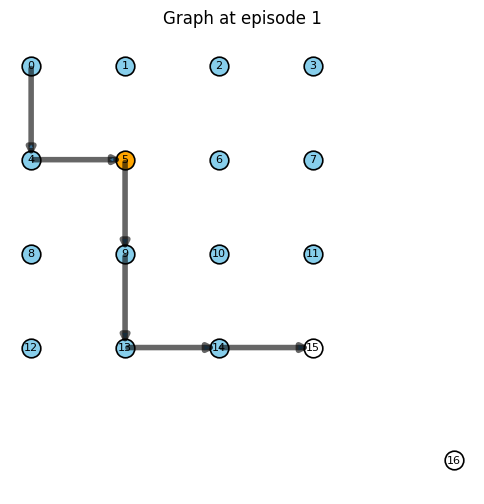

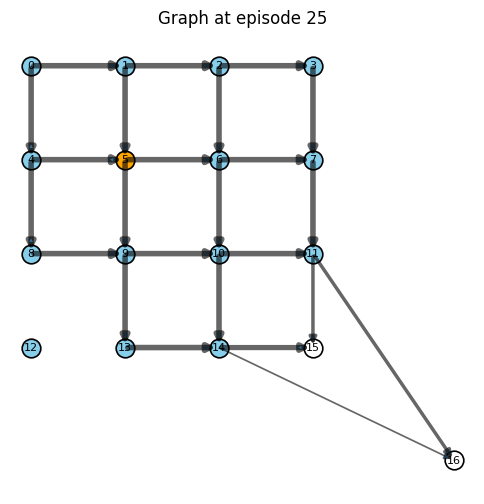

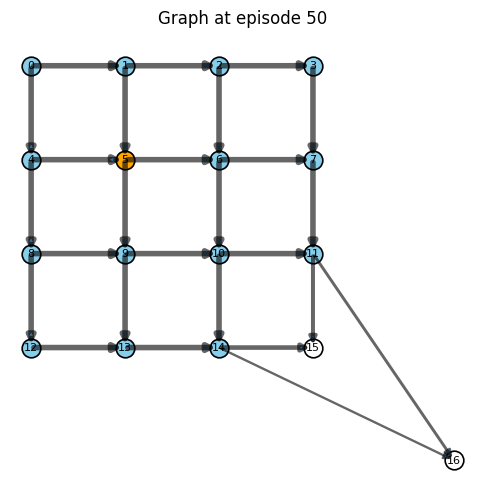

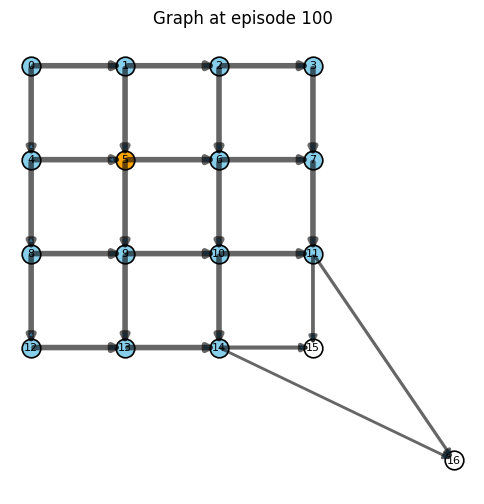

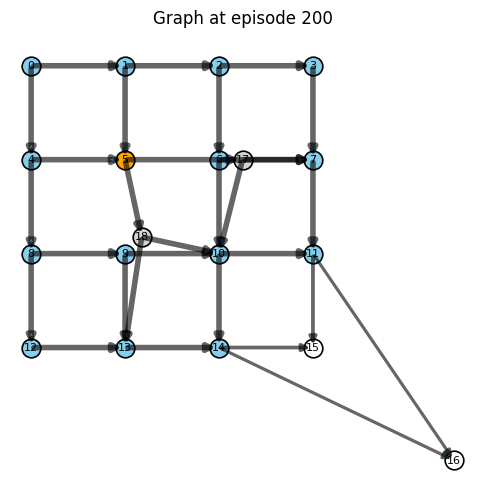

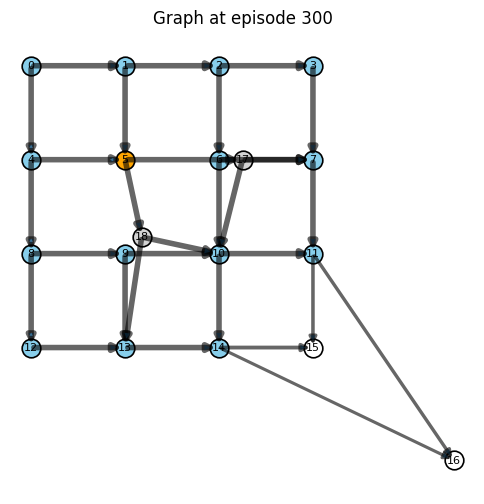

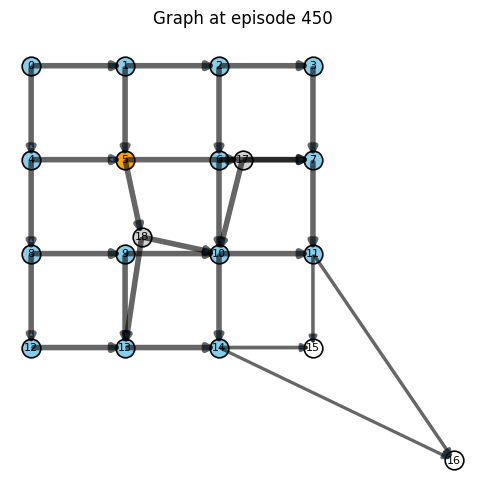

In [3]:

episodes_to_show = [1, 25, 50, 100, 200, 300, 450]
for ep in episodes_to_show:
    idx = min(max(1, ep), len(T_snapshots)) - 1
    plot_graph_at_episode(idx, prob_threshold=0.05, figsize=(6,6), title=f"Graph at episode {ep}")


## Save snapshots to PNG

In [4]:

outdir = '/mnt/data/coda_graph_snaps'
import os
os.makedirs(outdir, exist_ok=True)
for ep in [25, 100, 200, 300, 450]:
    idx = min(max(1, ep), len(T_snapshots)) - 1
    import matplotlib.pyplot as plt
    plot_graph_at_episode(idx, prob_threshold=0.05, figsize=(6,6), title=f"Graph at episode {ep}")
    plt.savefig(f"{outdir}/graph_ep{ep}.png", bbox_inches='tight', dpi=180)
print('Saved to', outdir)


OSError: [Errno 30] Read-only file system: '/mnt'